<a href="https://colab.research.google.com/github/bartexx37/DeepLearning/blob/main/Pub_Med_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Sklimlit Project

- Replicating paper : https://arxiv.org/pdf/1710.06071.pdf
- Architecture for project : https://arxiv.org/pdf/1612.05251.pdf

#Confirm access to a GPU

In [2]:
!nvidia-smi -L

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [3]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
import helper_functions as hp

--2023-02-24 12:06:00--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-02-24 12:06:00 (62.7 MB/s) - ‘helper_functions.py’ saved [10246/10246]



# Get data

- Dataset from PubMed 200k RCT, taking it from authors Github linked in paper: https://github.com/Franck-Dernoncourt/pubmed-rct

- Dev.txt - another word in machine learning for calidation dataset


In [4]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 5), reused 5 (delta 5), pack-reused 25
Unpacking objects: 100% (33/33), 177.08 MiB | 9.47 MiB/s, done.
Updating files: 100% (13/13), done.


In [5]:
!ls pubmed-rct

PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [6]:
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/
'''
There are 3 files:
1. dev.txt - validation dataset
2. test.txt - test dataset
3. train.txt - train dataset
'''

dev.txt  test.txt  train.txt


'\nThere are 3 files:\n1. dev.txt - validation dataset\n2. test.txt - test dataset\n3. train.txt - train dataset\n'

In [7]:
import os
data_dir = "pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt']

# Preprocessing Data

In [8]:
def get_lines(filename):
  '''
  Reads filename (txt) returns list of lines

  Args:
    filename: a string containing target filepath
  
  Return: List of strings - one string per line
  '''
  with open(filename, "r") as f:
    return f.readlines()

Get data in form of list of directories like :
```
[{'line_num': num,
  'target': e.g. 'BACKGROUND',
  'text': e.g  "Pain was assessed using the visual analog pain scale ( @-@ mm ) .\n",
  'num_of_lines': lines for one article},
next sentences...]
```

In [9]:
def preprocess_lines(filename):
  lines = get_lines(filename) #Getting lines from filename
  #Prepare text for learning
  train_data=[]
  j=0
  for i,line in enumerate(lines):
    if line.startswith("###"):
      for k,check_line in enumerate(lines[i:]):
        if check_line.isspace():
          break
    elif line.isspace():
      j=0
    else:
      train_data.append({'line_num': j,
                        'target': line.split("\t")[0],
                        'text': line.split("\t")[1][:-1].lower(),
                        'num_of_lines':k-2})#Substracting 2 because of first ### line and last "\n" line
      j+=1
  return train_data

In [10]:
%%time

train_samples = preprocess_lines(data_dir+"train.txt")
val_samples = preprocess_lines(data_dir+"dev.txt")
test_samples = preprocess_lines(data_dir+"test.txt")

print(len(train_samples),len(val_samples),len(test_samples))

180040 30212 30135
CPU times: user 25.5 s, sys: 306 ms, total: 25.8 s
Wall time: 25.9 s


In [11]:
train_samples[:14]

[{'line_num': 0,
  'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'num_of_lines': 11},
 {'line_num': 1,
  'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'num_of_lines': 11},
 {'line_num': 2,
  'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'num_of_lines': 11},
 {'line_num': 3,
  'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'num_of_lines': 11},
 {'line_num': 4,
  'target': 'METHODS',
  'text': 'secondary outcome measures included the weste

In [12]:
import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)
train_df.head(14)

,line_num,target,text,num_of_lines
0,0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,11
1,1,METHODS,a total of @ patients with primary knee oa wer...,11
2,2,METHODS,outcome measures included pain reduction and i...,11
3,3,METHODS,pain was assessed using the visual analog pain...,11
4,4,METHODS,secondary outcome measures included the wester...,11
5,5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",11
6,6,RESULTS,there was a clinically relevant reduction in t...,11
7,7,RESULTS,the mean difference between treatment arms ( @...,11
8,8,RESULTS,"further , there was a clinically relevant redu...",11
9,9,RESULTS,these differences remained significant at @ we...,11


In [13]:
#Distribution of labels
train_df.target.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

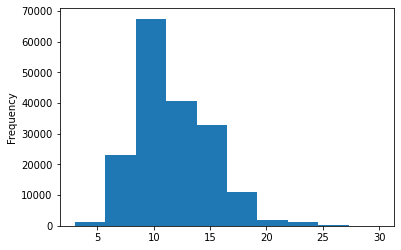

In [14]:
#Distribution of lenght of different lines
train_df.num_of_lines.plot.hist();

#List of sentences

In [15]:
#Making data ready to learning
train_sentences = train_df["text"].tolist()
val_sentences=val_df["text"].tolist()
test_sentences=test_df["text"].tolist()
len(train_sentences),len(val_sentences),len(test_sentences)

(180040, 30212, 30135)

In [16]:
# Make labels numeric for ML models
import tensorflow as tf
from sklearn.preprocessing import OneHotEncoder
ohc = OneHotEncoder(sparse=False)
train_labels_oh = tf.constant(ohc.fit_transform(train_df["target"].to_numpy().reshape(-1,1)))#Fit only to train data
val_labels_oh = tf.constant(ohc.transform(val_df["target"].to_numpy().reshape(-1,1)))
test_labels_oh = tf.constant(ohc.transform(test_df["target"].to_numpy().reshape(-1,1)))
train_labels_oh, len(train_labels_oh)

(<tf.Tensor: shape=(180040, 5), dtype=float64, numpy=
 array([[0., 0., 0., 1., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0.],
        ...,
        [0., 0., 0., 0., 1.],
        [0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0.]])>, 180040)

In [17]:
#Cand also encode labels
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encode = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encode = label_encoder.transform(val_df["target"].to_numpy())
test_labels_encode = label_encoder.transform(test_df["target"].to_numpy())
train_labels_encode,len(train_labels_encode)

(array([3, 2, 2, ..., 4, 1, 1]), 180040)

In [18]:
#Get class names and number of them
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names


(5, array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

## MODEL 0 - Naive Bayes as baseline

-  Multinomial

In [ ]:
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
#Build
model_0 = Pipeline([('tf-idf', TfidfVectorizer()),
                    ('clf', MultinomialNB())])
model_0.fit(train_sentences,train_labels_encode)

Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [ ]:
#Evaluate
model_0.score(X=val_sentences,y=val_labels_encode)

0.7218323844829869

In [ ]:
#Making predictions and gettign evaluation metrics
model_0_predictions = model_0.predict(val_sentences)
model_0_results = hp.calculate_results(val_labels_encode,model_0_predictions)
model_0_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

# Preparing data for deep learning

- Tokenization, Word Embedding

In [19]:
#Length of sentences average
import numpy as np
sentence_lengths =  [len(sentence.split()) for sentence in train_sentences]
avg_length = np.mean(sentence_lengths)
max_length = np.max(sentence_lengths)
avg_length, max_length 

(26.338269273494777, 296)

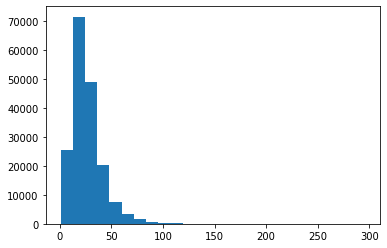

In [20]:
import matplotlib.pyplot as plt
plt.hist(sentence_lengths,bins=25);

In [21]:
percentile_sent = int(np.percentile(sentence_lengths,95))
percentile_sent
#95% is under 55 length

55

Use length of 55 then as length of sequences for vectorization and embedding

Also taking from paper given at the beggining, max tokens will be set as an amount of words in 20K PubMed DataSet

In [22]:
import tensorflow as tf
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras.layers import Embedding

max_tokens = 68000
sequence_length = percentile_sent

#Text Vectorizer layer 
text_vectorizer = TextVectorization(max_tokens = max_tokens,
                                    output_mode = "int",
                                    output_sequence_length=sequence_length)

In [23]:
#Adapt text vectorizer to train_data
text_vectorizer.adapt(train_sentences)

In [24]:
#Test text vectorizer
import random
target_sentence = random.choice(train_sentences)
print(f"Text:\n{target_sentence}")
print(f"\nlength = {len(target_sentence.split())}")
print(f"\nText:\n{text_vectorizer([target_sentence])}")

Text:
this randomized , double-blind phase @ trial compared apf@ and palonosetron in preventing acute and delayed cinv after moderately ( mec ) or highly emetogenic chemotherapy ( hec ) .

length = 30

Text:
[[   23    29   236   209    32    34 10875     3  7818     5  1126   229
      3  1013  8961    21  2820 15773    16   862 12148   415 13269     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]


In [25]:
pubMed_20k_vocab = text_vectorizer.get_vocabulary()
print(f"Len of Vocabulary: {len(pubMed_20k_vocab)}\n")
print(f"Most Common:\n{pubMed_20k_vocab[:5]}")
print(f"\nRare:\n{pubMed_20k_vocab[-5:]}")

Len of Vocabulary: 64841

Most Common:
['', '[UNK]', 'the', 'and', 'of']

Rare:
['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [26]:
embedding_layer = Embedding(input_dim=len(pubMed_20k_vocab),
                            output_dim=128,
                            mask_zero=True, #It will mask out zeros - A lot of special 'padding' - thank to this - more efficient,
                            name="embedding_layer" 
                            )

In [ ]:
#Check random samples going through embedding
import random
target_sentence = random.choice(train_sentences)
print(f"Text:\n{target_sentence}")
print(f"\nVectorized Text:\n{text_vectorizer([target_sentence])}")
print(f"\nEmbedded Text{embedding_layer(text_vectorizer([target_sentence]))}")
print(f"\nShape of embedded text:{embedding_layer(text_vectorizer([target_sentence])).shape} ")

Text:
the trial is registered with clinical trial registry-india ( ctri/@/@ / @ ) and clinicaltrials.gov ( nct@ ) .

Vectorized Text:
[[    2    32    20   394     7    47    32 19744  7246     3   275   176
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]

Embedded Text[[[-0.02745211  0.04366327 -0.01287667 ...  0.04601804 -0.04724169
   -0.0485201 ]
  [-0.02836732  0.04168599  0.0405564  ... -0.04337115  0.0387206
    0.01289013]
  [-0.03209452  0.01228761  0.0237206  ... -0.00418018 -0.01968961
    0.02943346]
  ...
  [ 0.00424714  0.04387765  0.03675172 ... -0.04776631 -0.04390858
    0.01003446]
  [ 0.00424714  0.04387765  0.03675172 ... -0.04776631 -0.04390858
    0.01003446]
  [ 0.00424714  0.04387765  0.03675172 ... -0.04776631 -0.04390858
    0.01003446]]]

Shap

## Creating dataset - using tf.data APi
- making as efficient as possible

https://www.tensorflow.org/guide/data?hl=pl



In [27]:
#Turn list and numpy array to TensorflowSliceDataset
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences,train_labels_oh))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences,val_labels_oh))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences,test_labels_oh))
train_dataset

<TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [28]:
train_labels_oh.shape

TensorShape([180040, 5])

In [29]:
#Turn to prefeched Datasets
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)#Don't shuffle, because order in this case is crucial
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
train_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

# Model1 : Conv1D

Build and compile model

In [ ]:
from tensorflow.keras import layers
#Build model
inputs = layers.Input(shape=(1,),dtype=tf.string) # One sequence at the time
x = text_vectorizer(inputs)
x = embedding_layer(x)
x = layers.Conv1D(filters=64,
                  kernel_size=5,
                  padding="same",
                  activation="relu",
                  )(x)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(5,activation="softmax")(x)
model_1 = tf.keras.Model(inputs,outputs,name="model_1_conv1D")

#Compile model
model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])
#Summary
model_1.summary()

Model: "model_1_conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 55)               0         
 torization)                                                     
                                                                 
 embedding_layer (Embedding)  (None, 55, 128)          8299648   
                                                                 
 conv1d (Conv1D)             (None, 55, 64)            41024     
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 5)              

Create callbacks

In [79]:
SAVE_DIR = "models/"
tensorboard_callback = hp.create_tensorboard_callback(SAVE_DIR,
                                                      "model_1")
model_checkpoint = tf.keras.callbacks.ModelCheckpoint("Model_1_Checkpoint",
                                                      monitor="val_accuracy",
                                                      save_best_only=True,
                                                      save_weights_only=True,
                                                      verbose=1)


Saving TensorBoard log files to: models//model_1/20230224-121213


Fit model

In [ ]:
history_1=model_1.fit(train_dataset,
                      steps_per_epoch=int(0.1*len(train_dataset)),#Train on 10% of data
                      epochs=3,
                      validation_data=valid_dataset,
                      validation_steps=int(0.1*len(valid_dataset)),
                      callbacks=[tensorboard_callback,model_checkpoint])  

Epoch 1/3
562/562 [==============================] - ETA: 0s - loss: 0.8285 - accuracy: 0.6852
Epoch 1: val_accuracy improved from -inf to 0.78092, saving model to Model_1_Checkpoint
562/562 [==============================] - 35s 45ms/step - loss: 0.8285 - accuracy: 0.6852 - val_loss: 0.5821 - val_accuracy: 0.7809
Epoch 2/3
560/562 [============================>.] - ETA: 0s - loss: 0.5763 - accuracy: 0.7895
Epoch 2: val_accuracy improved from 0.78092 to 0.79953, saving model to Model_1_Checkpoint
562/562 [==============================] - 7s 13ms/step - loss: 0.5760 - accuracy: 0.7898 - val_loss: 0.5375 - val_accuracy: 0.7995
Epoch 3/3
555/562 [============================>.] - ETA: 0s - loss: 0.5432 - accuracy: 0.7990
Epoch 3: val_accuracy improved from 0.79953 to 0.81316, saving model to Model_1_Checkpoint
562/562 [==============================] - 5s 9ms/step - loss: 0.5432 - accuracy: 0.7987 - val_loss: 0.5208 - val_accuracy: 0.8132


Evaluation

In [ ]:
model_1.evaluate(valid_dataset)

945/945 [==============================] - 4s 4ms/step - loss: 0.5229 - accuracy: 0.8073


[0.5228847861289978, 0.8072951436042786]

In [ ]:
model_1_pred_probs = model_1.predict(val_sentences)
model_1_pred_probs[:4]

945/945 [==============================] - 3s 3ms/step


array([[5.9450775e-01, 6.7739017e-02, 1.2370958e-03, 3.3225143e-01,
        4.2646928e-03],
       [2.2376755e-01, 6.3442773e-01, 8.3782524e-04, 1.3773049e-01,
        3.2363897e-03],
       [1.9643961e-01, 1.0450406e-02, 3.2206681e-03, 7.8958547e-01,
        3.0386684e-04],
       [4.0103844e-03, 8.2931481e-03, 9.1769475e-01, 3.4203299e-03,
        6.6581465e-02]], dtype=float32)

In [ ]:
model_1_predictions = tf.argmax(model_1_pred_probs,axis=1)
model_1_predictions[:4]

<tf.Tensor: shape=(4,), dtype=int64, numpy=array([0, 1, 3, 2])>

In [ ]:
class_names

array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
      dtype=object)

In [ ]:
model_1_results = hp.calculate_results(val_labels_encode,model_1_predictions)
model_1_results

{'accuracy': 80.72951145240302,
 'precision': 0.8055887844050444,
 'recall': 0.8072951145240301,
 'f1': 0.8056079599829649}

In [ ]:
model_0_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

# Model2 : Using TF_HUB Pretrained Feature Extractor

- Using universal sentence encoder: https://tfhub.dev/google/universal-sentence-encoder/4

Build and compile model

In [41]:
import tensorflow_hub as hub
from tensorflow.keras import layers
import tensorflow as tf
#Build model
feature_extractor = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                   trainable=False,
                                   input_shape=[],
                                   dtype=tf.string)
#model_2 = tf.keras.Sequential([
#    feature_extractor,
#    layers.Dense(64,activation="relu"),
#    layers.Dense(5,activation="softmax")
#])

inputs = layers.Input(shape=[],dtype=tf.string)
x = feature_extractor(inputs)
x=layers.Dense(128,activation="relu")(x)
outputs=layers.Dense(5,activation="softmax")(x)
model_2 = tf.keras.Model(inputs,outputs,name="MODEL_2_USE")

#Compile model
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])
#Summary
model_2.summary()

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Model: "MODEL_2_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None,)]                 0         
                                                                 
 keras_layer (KerasLayer)    (None, 512)               256797824 
                                                                 
 dense (Dense)               (None, 128)               65664     
                                                                 
 dense_1 (Dense)             (None, 5)                 645       
                                                                 
Total params: 256,864,133
Trainable params: 66,309
Non-trainable params: 256,797,824
_________________________________________________________________


Fit model

In [ ]:
history_2 = model_2.fit(train_dataset,
                        steps_per_epoch=int(0.1*len(train_dataset)),
                        epochs=3,
                        validation_data=valid_dataset,
                        validation_steps=int(0.1*len(valid_dataset)),
                        callbacks=[tensorboard_callback,model_checkpoint]
                        )

Epoch 1/3
562/562 [==============================] - ETA: 0s - loss: 0.9168 - accuracy: 0.6480
Epoch 1: val_accuracy did not improve from 0.81316
562/562 [==============================] - 13s 16ms/step - loss: 0.9168 - accuracy: 0.6480 - val_loss: 0.7975 - val_accuracy: 0.6888
Epoch 2/3
560/562 [============================>.] - ETA: 0s - loss: 0.7697 - accuracy: 0.7017
Epoch 2: val_accuracy did not improve from 0.81316
562/562 [==============================] - 7s 13ms/step - loss: 0.7698 - accuracy: 0.7015 - val_loss: 0.7573 - val_accuracy: 0.7031
Epoch 3/3
561/562 [============================>.] - ETA: 0s - loss: 0.7540 - accuracy: 0.7124
Epoch 3: val_accuracy did not improve from 0.81316
562/562 [==============================] - 8s 15ms/step - loss: 0.7540 - accuracy: 0.7125 - val_loss: 0.7404 - val_accuracy: 0.7111


Evaluation

In [ ]:
model_2.evaluate(valid_dataset)

945/945 [==============================] - 11s 12ms/step - loss: 0.7419 - accuracy: 0.7135


[0.7418671250343323, 0.713458240032196]

In [ ]:
model_2_predprobs=model_2.predict(val_sentences)
model_2_predprobs[:4]

945/945 [==============================] - 11s 11ms/step


array([[0.4339981 , 0.34113204, 0.00214479, 0.21593563, 0.00678944],
       [0.32664734, 0.5213859 , 0.00389831, 0.14452025, 0.0035482 ],
       [0.21870892, 0.13150698, 0.01641509, 0.5926829 , 0.04068604],
       [0.01206359, 0.04928122, 0.80447406, 0.00888797, 0.12529318]],
      dtype=float32)

In [ ]:
model_2_predicts = tf.argmax(model_2_predprobs,axis=1)
model_2_predicts[:4]

<tf.Tensor: shape=(4,), dtype=int64, numpy=array([0, 1, 3, 2])>

In [ ]:
#Calculate results
model_2_results = hp.calculate_results(val_labels_encode,model_2_predicts)
model_2_results

{'accuracy': 71.34582285184695,
 'precision': 0.7137912185386411,
 'recall': 0.7134582285184695,
 'f1': 0.7105491797931515}

In [ ]:
model_0_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

# Model 3: Conv1D with character embeddings

-To eventaully use concatenation of both token and character embedding as in paper shown at the beggining

Dealing with data for character embedding

In [62]:
#To use character embedding it is needed to change sentences from e.g. ['it is dog'] to ['i','t',' ','i'...]
import random
def text_to_char(text):
  return " ".join(list(text))
text_to_char(random.choice(train_sentences))

'c b s p p   i s   a   f e a s i b l e   i n t e r v e n t i o n   w h i c h   h a s   t h e   p o t e n t i a l   t o   r e d u c e   p r o x y   m e a s u r e s   o f   s u i c i d e   i n   p s y c h o t i c   p a t i e n t s   .'

In [63]:
#Split sequence-level data splits into character-level data splits
train_chars = [text_to_char(sentence) for sentence in train_sentences]
val_chars = [text_to_char(sentence) for sentence in val_sentences]
test_chars = [text_to_char(sentence) for sentence in test_sentences]
train_chars[:3]

['t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .',
 'a   t o t a l   o f   @   p a t i e n t s   w i t h   p r i m a r y   k n e e   o a   w e r e   r a n d o m i z e d   @ : @   ;   @   r e c e i v e d   @   m g / d a y   o f   p r e d n i s o l o n e   a n d   @   r e c e i v e d   p l a c e b o   f o r   @   w e e k s   .',
 'o u t c o m e   m e a s u r e s   i n c l u d e d   p a i n   r e d u c t i o n   a n d   i m p r o v e m e n t   i n   f u n c t i o n   s c o r e s   a 

In [64]:
#Average character lenght
char_len = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(char_len)
mean_char_len

149.3662574983337

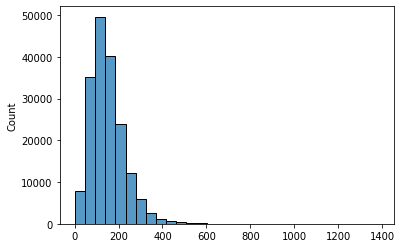

In [65]:
#Check the distribution
import seaborn as sns 
sns.histplot(char_len,bins=30);

In [66]:
#getting <95% of char length
char_95_percentile = int(np.percentile(char_len,95))
char_95_percentile

290

In [67]:
#Getting all keyboard characters
import string
alphabet = string.ascii_lowercase+string.digits+string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

Creating character vectorizer instance and embedding layer

In [68]:
num_char = len(alphabet)+2 # 1 for space, another for OOv - out of vocab
char_vectorizer = TextVectorization(max_tokens = num_char,
                                    output_mode="int",
                                    output_sequence_length=char_95_percentile)
#Adapt Vectorizer
char_vectorizer.adapt(train_chars)
char_vocab = char_vectorizer.get_vocabulary()

embedding_char_layer = tf.keras.layers.Embedding(input_dim=len(char_vocab),
                                                 output_dim=25,
                                                 mask_zero=True)

In [69]:
len(char_vocab), char_vocab[:5], char_vocab[-5:]

(28, ['', '[UNK]', 'e', 't', 'i'], ['k', 'x', 'z', 'q', 'j'])

In [70]:
random_char_sentence = random.choice(train_chars)
print(f"Char sentence:\n{random_char_sentence}\n")
print(f"Embeded char sentence:\n{embedding_char_layer(char_vectorizer([random_char_sentence]))}")
print(f"\nEmbedded shape:{embedding_char_layer(char_vectorizer([random_char_sentence])).shape}")

Char sentence:
i n   t h e   a c u p u n c t u r e   g r o u p   ,   a c u p u n c t u r e   w a s   a p p l i e d   a t   t h r e e - n o s e   p o i n t s   - l s b -   y i n g x i a n g   (   l i   @   )   ,   s h a n g y i n g x i a n g   (   e x - h n   @   )   a n d   y i n t a n g   (   g v   @   )   ;   c u a n z h u   (   b l   @   )   w a s   a d d e d   f o r   f r o n t a l   h e a d a c h e   - r s b -   a n d   t h r e e - b a c k   p o i n t s   - l s b -   d a z h u   (   b l   @   )   ,   f e n g m e n   (   b l   @   )   a n d   f e i s h u   (   b l   @   )   - r s b -   ,   o n c e   e v e r y   d a y   .

Embeded char sentence:
[[[ 0.00273013  0.00223935  0.02574987 ... -0.03951895  0.04627874
   -0.004667  ]
  [ 0.03319727  0.02989718  0.01495986 ...  0.0016472   0.01801689
    0.01080859]
  [ 0.00690709  0.03738416  0.01829201 ...  0.04759574 -0.02302748
   -0.03347186]
  ...
  [ 0.0047037  -0.01559623  0.04426334 ... -0.02391998  0.02321247
   -0.01297009]
  [ 0

Model 3: Conv1D - Character embedding

Build and compile model

In [ ]:
from tensorflow.keras import layers
#Build model
inputs = layers.Input(shape=(1,),dtype=tf.string)
vectorizer = char_vectorizer(inputs)
embedding = embedding_char_layer(vectorizer)
x = layers.Conv1D(filters=64,
                  kernel_size=5,
                  activation="relu",
                  padding="same")(embedding)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(5,activation="softmax")(x)
model_3 = tf.keras.Model(inputs,outputs,name="model_3_Conv1D_CharEmb")

#Compile model
model_3.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])
#Summary
model_3.summary()

Model: "model_3_Conv1D_CharEmb"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 290)              0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 290, 25)           700       
                                                                 
 conv1d_1 (Conv1D)           (None, 290, 64)           8064      
                                                                 
 global_max_pooling1d_1 (Glo  (None, 64)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_3 (Dense)             (None, 5)      

In [ ]:
#Getting data into tensorflow datasets
train_chars_dataset = tf.data.Dataset.from_tensor_slices((train_chars,train_labels_oh)).batch(32).prefetch(tf.data.AUTOTUNE)
valid_chars_dataset = tf.data.Dataset.from_tensor_slices((val_chars,val_labels_oh)).batch(32).prefetch(tf.data.AUTOTUNE)
test_chars_dataset = tf.data.Dataset.from_tensor_slices((test_chars,test_labels_oh)).batch(32).prefetch(tf.data.AUTOTUNE)

Fit Model

In [ ]:
#Fit model
history_3 = model_3.fit(train_chars_dataset,
                        steps_per_epoch=int(0.1*len(train_chars_dataset)),
                        epochs=3,
                        validation_data=valid_chars_dataset,
                        validation_steps=int(0.1*len(valid_chars_dataset)),
                        callbacks=[tensorboard_callback,model_checkpoint])


Epoch 1/3
555/562 [============================>.] - ETA: 0s - loss: 1.2539 - accuracy: 0.4862
Epoch 1: val_accuracy did not improve from 0.81316
562/562 [==============================] - 5s 7ms/step - loss: 1.2505 - accuracy: 0.4877 - val_loss: 1.0391 - val_accuracy: 0.5888
Epoch 2/3
555/562 [============================>.] - ETA: 0s - loss: 1.0017 - accuracy: 0.6021
Epoch 2: val_accuracy did not improve from 0.81316
562/562 [==============================] - 3s 6ms/step - loss: 1.0001 - accuracy: 0.6026 - val_loss: 0.9428 - val_accuracy: 0.6287
Epoch 3/3
561/562 [============================>.] - ETA: 0s - loss: 0.9186 - accuracy: 0.6392
Epoch 3: val_accuracy did not improve from 0.81316
562/562 [==============================] - 4s 7ms/step - loss: 0.9185 - accuracy: 0.6391 - val_loss: 0.8716 - val_accuracy: 0.6659


<AxesSubplot:>

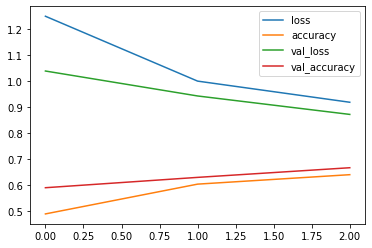

In [ ]:
pd.DataFrame(history_3.history).plot()

In [ ]:
model_3.evaluate(valid_chars_dataset)

945/945 [==============================] - 4s 4ms/step - loss: 0.8830 - accuracy: 0.6581


[0.8829777240753174, 0.6581490635871887]

In [ ]:
model_3_pred_probs = model_3.predict(val_chars)
model_3_pred_probs[:3]

945/945 [==============================] - 3s 3ms/step


array([[0.11132216, 0.48394305, 0.06590797, 0.21946514, 0.11936165],
       [0.17544235, 0.4487555 , 0.04371643, 0.1975152 , 0.13457051],
       [0.13624683, 0.26351392, 0.07512798, 0.49021798, 0.03489324]],
      dtype=float32)

In [ ]:
model_3_predicts = tf.argmax(model_3_pred_probs,axis=1)
model_3_predicts[:3]

<tf.Tensor: shape=(3,), dtype=int64, numpy=array([1, 1, 3])>

In [ ]:
#Calculate results of model 3
model_3_results = hp.calculate_results(val_labels_encode,model_3_predicts)
model_3_results

{'accuracy': 65.81490798358269,
 'precision': 0.6526051425989488,
 'recall': 0.6581490798358268,
 'f1': 0.6510524726394785}

# Model 4 : Combine pretrained token embeddings + character embeddings

1. Create a token-level embedding Model
2. Create a character-level model
3. Combine both with concatenate layer (layers.Concatenate)
4. Build a series of output layers on top of 3 similar to Figure 1 and 4.2 section of paper
5. Construct model which takes both token and character embedding sequences as input and pred probas as output

In [ ]:
#Dropout randomly exchanging to 0 values given part of inputs - for regularization - prevent overfitting
from tensorflow.keras import layers
import tensorflow as tf

#1. Token-level embedding model
token_inputs = layers.Input(shape=[],dtype=tf.string, name="token_input")
embedd_layer = feature_extractor(token_inputs)
token_outputs = layers.Dense(128,activation="relu")(embedd_layer)

token_model = tf.keras.Model(token_inputs,token_outputs)

#2. Character-level model
char_inputs = layers.Input(shape=(1,),dtype=tf.string,name="char_input")
vectorization = char_vectorizer(char_inputs)
embedding_chars = embedding_char_layer(vectorization)
char_outputs = layers.Bidirectional(layers.LSTM(units=24))(embedding_chars)

char_model = tf.keras.Model(char_inputs, char_outputs)

#3.Combine both
token_char_combine = layers.Concatenate(name="combine_char_token")([token_model.output,char_model.output])

#4. Build output layers
dropout = layers.Dropout(0.5)(token_char_combine)
x = layers.Dense(128,activation="relu")(dropout)
final_dropout = layers.Dropout(0.5)(x)
end_outputs = layers.Dense(5,activation="softmax")(final_dropout)

model_4 = tf.keras.Model(inputs=[token_inputs,char_inputs],
                         outputs=end_outputs,
                         name="model_4_Combined")

model_4.summary()

Model: "model_4_Combined"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 token_input (InputLayer)       [(None,)]            0           []                               
                                                                                                  
 text_vectorization_1 (TextVect  (None, 290)         0           ['char_input[0][0]']             
 orization)                                                                                       
                                                                                                  
 keras_layer (KerasLayer)       (None, 512)          256797824   ['token_input[0][0

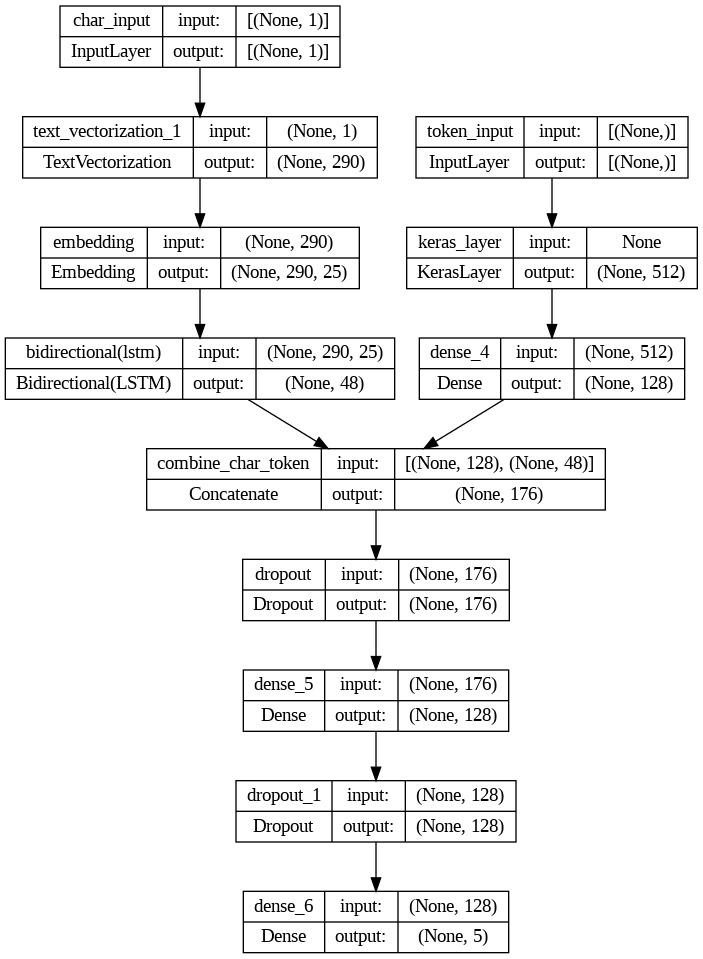

In [ ]:
 from keras.utils import plot_model
 plot_model(model_4, show_shapes=True)

Compile Model

In [ ]:
model_4.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

Preprocess data as multi-input tensorflow Datasets

In [ ]:
concatenated_train_data = tf.data.Dataset.from_tensor_slices((train_sentences,train_chars))
concatenated_train_labels = tf.data.Dataset.from_tensor_slices((train_labels_oh))
concatenated_train_dataset = tf.data.Dataset.zip((concatenated_train_data,concatenated_train_labels))#Combining tensorflow Datasets
#Prefetch and make batches
concatenated_train_dataset=concatenated_train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
#Same for validation dataset
concatenated_val_data = tf.data.Dataset.from_tensor_slices((val_sentences,val_chars))
concatenated_val_labels = tf.data.Dataset.from_tensor_slices((val_labels_oh))
concatenated_val_dataset = tf.data.Dataset.zip((concatenated_val_data,concatenated_val_labels))
#Prefetch and make batches
concatenated_val_dataset=concatenated_val_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
concatenated_train_dataset,concatenated_val_dataset

(<PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

Fit the model

In [ ]:
history_4 = model_4.fit(concatenated_train_dataset,
                        epochs=3,
                        steps_per_epoch=int(0.1*len(concatenated_train_dataset)),
                        validation_data=concatenated_val_dataset,
                        validation_steps=int(0.1*len(concatenated_val_dataset)),
                        callbacks=[tensorboard_callback,model_checkpoint])

Epoch 1/3
562/562 [==============================] - ETA: 0s - loss: 0.9851 - accuracy: 0.6029
Epoch 1: val_accuracy did not improve from 0.81316
562/562 [==============================] - 41s 54ms/step - loss: 0.9851 - accuracy: 0.6029 - val_loss: 0.7831 - val_accuracy: 0.6945
Epoch 2/3
562/562 [==============================] - ETA: 0s - loss: 0.8041 - accuracy: 0.6873
Epoch 2: val_accuracy did not improve from 0.81316
562/562 [==============================] - 28s 51ms/step - loss: 0.8041 - accuracy: 0.6873 - val_loss: 0.7182 - val_accuracy: 0.7264
Epoch 3/3
562/562 [==============================] - ETA: 0s - loss: 0.7789 - accuracy: 0.7028
Epoch 3: val_accuracy did not improve from 0.81316
562/562 [==============================] - 25s 45ms/step - loss: 0.7789 - accuracy: 0.7028 - val_loss: 0.6933 - val_accuracy: 0.7360


In [ ]:
model_4.evaluate(concatenated_val_dataset)

945/945 [==============================] - 20s 22ms/step - loss: 0.6980 - accuracy: 0.7335


[0.6980135440826416, 0.7335164546966553]

In [ ]:
model_4_pred_probs=model_4.predict(concatenated_val_dataset) # ???????????????
model_4_pred_probs

945/945 [==============================] - 22s 20ms/step


array([[4.5459077e-01, 3.4858426e-01, 4.0932037e-03, 1.8535857e-01,
        7.3731928e-03],
       [3.0006593e-01, 5.3569180e-01, 3.1404807e-03, 1.5933275e-01,
        1.7690486e-03],
       [3.0382472e-01, 1.7844084e-01, 4.8142787e-02, 4.2675704e-01,
        4.2834543e-02],
       ...,
       [3.4271338e-04, 5.8712820e-03, 6.0145259e-02, 1.3389514e-04,
        9.3350679e-01],
       [9.8602409e-03, 6.7108884e-02, 2.3354451e-01, 4.0907850e-03,
        6.8539560e-01],
       [2.3109172e-01, 4.7365531e-01, 2.2558418e-01, 1.9074155e-02,
        5.0594687e-02]], dtype=float32)

In [ ]:
model_4_predicts = tf.argmax(model_4_pred_probs,axis=1)
model_4_predicts[:5]

<tf.Tensor: shape=(5,), dtype=int64, numpy=array([0, 1, 3, 2, 2])>

In [ ]:
model_4_results = hp.calculate_results(val_labels_encode,model_4_predicts)
model_4_results

{'accuracy': 73.35164835164835,
 'precision': 0.734785682423711,
 'recall': 0.7335164835164835,
 'f1': 0.7305987364508678}

# Model 5 : Both embeddings + positional embedding

Preparing data for the model fitting

In [42]:
train_df["line_num"].value_counts()


0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: line_num, dtype: int64

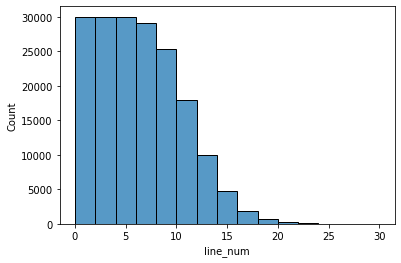

In [43]:
#Plot 
import seaborn as sns
sns.histplot(data=train_df,x="line_num",bins=15);

In [44]:
import numpy as np 
np.percentile(train_df["line_num"],98)

15.0

In [45]:
#Because of the fact that up to 15 is about 98% of all of the train data, then one_hot will be performed with depth=15
#To decrease size 2 times
train_line_num_oh = tf.one_hot(train_df["line_num"].to_numpy(),depth=15)
val_line_num_oh = tf.one_hot(val_df["line_num"].to_numpy(),depth=15)
test_line_num_oh = tf.one_hot(test_df["line_num"].to_numpy(),depth=15)
train_line_num_oh[:5]

<tf.Tensor: shape=(5, 15), dtype=float32, numpy=
array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
      dtype=float32)>

In [46]:
train_df["num_of_lines"].value_counts()

11    24468
10    23639
12    22113
9     19400
13    18438
14    14610
8     12285
15    10768
7      7464
16     7429
17     5202
6      3353
18     3344
19     2480
20     1281
5      1146
21      770
22      759
23      264
4       215
24      200
25      182
26       81
28       58
3        32
30       31
27       28
Name: num_of_lines, dtype: int64

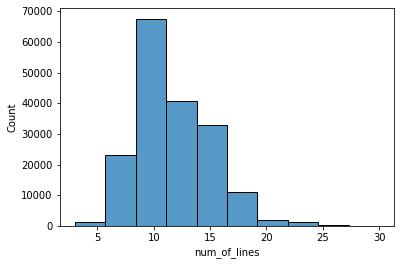

In [47]:
sns.histplot(data=train_df,x="num_of_lines",bins=10);

In [48]:
sum=0
for i in range(3,20):
  sum = sum + train_df["num_of_lines"].value_counts()[i]
sum

176386

In [49]:
#Calculate percent
perc = sum/len(train_df)*100
perc

97.97045101088648

In [50]:
#Due to the same fact as before - now depth will be 20
train_total_lines_oh = tf.one_hot(train_df["num_of_lines"].to_numpy(),depth=20)
val_total_lines_oh = tf.one_hot(val_df["num_of_lines"].to_numpy(),depth=20)
test_total_lines_oh = tf.one_hot(test_df["num_of_lines"].to_numpy(),depth=20)
#Of course any abstract above 20 will have vector covered with zeros
val_total_lines_oh[:2], val_total_lines_oh.shape

(<tf.Tensor: shape=(2, 20), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.]], dtype=float32)>, TensorShape([30212, 20]))

##  Building model 5

1. Create token-level model
2. Create character-level model
3. Create model for number of line 
4. Create model for all lines of abstracts
5. Combine models 1 and 2
6. Combine models 5 with 3,4
7. Output layer after combined models
8. Combine all four inputs

In [71]:
from tensorflow.keras import layers
#1. Token-level model
token_inputs = layers.Input(shape=[], dtype=tf.string,name="Token_input")
token_vectorizer = feature_extractor(token_inputs)
token_output = layers.Dense(units=128,activation="relu")(token_vectorizer)
token_model_5 = tf.keras.Model(token_inputs,token_output)

#2. Character-level model
character_inputs = layers.Input(shape=(1,),
                               dtype=tf.string,
                               name="Char_input",
                               )
character_vectorizer = char_vectorizer(character_inputs)
character_embedding = embedding_char_layer(character_vectorizer)
character_ouputs = layers.Bidirectional(layers.LSTM(32))(character_embedding)
character_model_5 = tf.keras.Model(character_inputs,character_ouputs)

#3. Num of lines model
num_lines_inputs = layers.Input(shape=(15,),
                                dtype=tf.float32,
                                name="num_lines_input")
num_lines_outputs = layers.Dense(32,activation="relu")(num_lines_inputs)
num_lines_model_5 = tf.keras.Model(num_lines_inputs,
                                   num_lines_outputs)

#4. All lines of abstract model
all_line_inputs = layers.Input(shape=(20,),
                               dtype=tf.float32,
                               name="all_lines_input")
all_line_outputs = layers.Dense(32,activation="relu")(all_line_inputs)
all_line_model_5 = tf.keras.Model(all_line_inputs,
                                  all_line_outputs)
#5. Concatenate model from 1/2
Concat_model_12 = layers.Concatenate(name="Concat_model_12")([token_model_5.output,
                                                              character_model_5.output])


a = layers.Dense(256,activation="relu")(Concat_model_12)
dropout_5 = layers.Dropout(0.5)(a) # Regularization

#6. Concatenate model from 3/4/5 
Concat_model_345 = layers.Concatenate(name="Concat_model_345")([num_lines_model_5.output,
                                                                all_line_model_5.output,
                                                                dropout_5])

#7. Output layer for all concatenated models
output_layer = layers.Dense(5,activation="softmax",name="output_layer")(Concat_model_345)

#8. Create end model
model_5 = tf.keras.Model(inputs=[num_lines_model_5.input,
                                 all_line_model_5.input,
                                 token_model_5.input,
                                 character_model_5.input],
                         outputs=output_layer,
                         name="model_5_tribrid")

In [72]:
#Summary
model_5.summary()

Model: "model_5_tribrid"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Char_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 Token_input (InputLayer)       [(None,)]            0           []                               
                                                                                                  
 text_vectorization_2 (TextVect  (None, 290)         0           ['Char_input[0][0]']             
 orization)                                                                                       
                                                                                                  
 keras_layer (KerasLayer)       (None, 512)          256797824   ['Token_input[0][0]

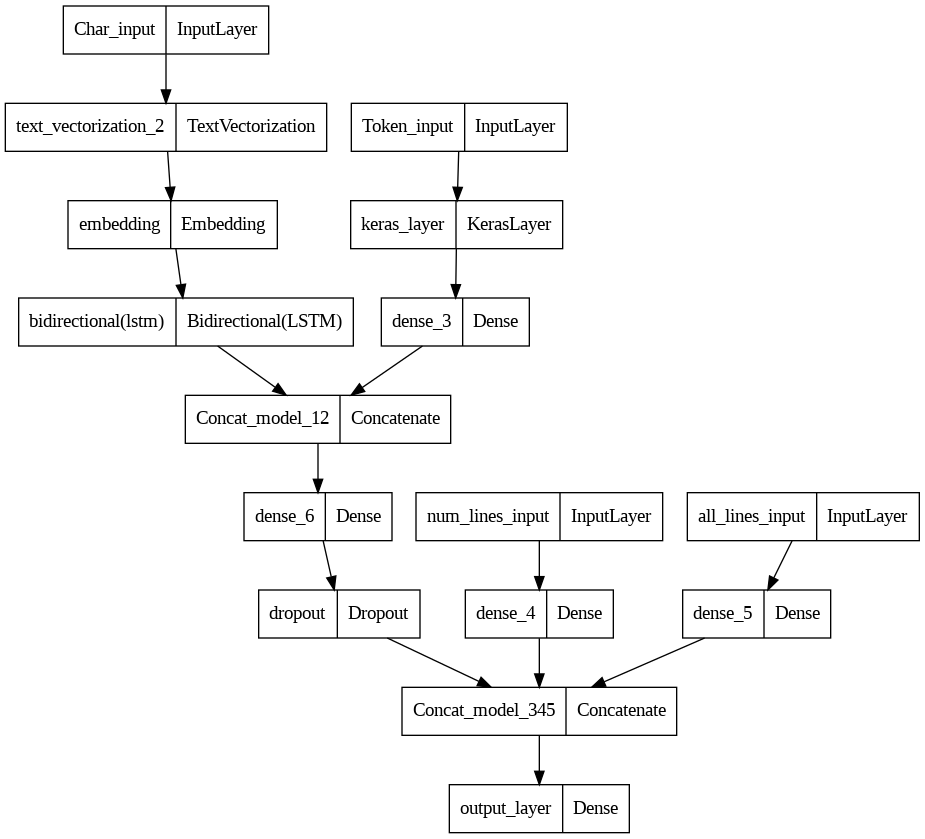

In [73]:
#Visualize model 5
from keras.utils import plot_model
plot_model(model_5)

Compile the Model

In [74]:
model_5.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

Make train dataset


In [75]:
train_all__sentence_dataset = tf.data.Dataset.from_tensor_slices((train_line_num_oh,
                                                                  train_total_lines_oh,
                                                                  train_sentences,
                                                                  train_chars))
                                                  
train_all_labels_dataset = tf.data.Dataset.from_tensor_slices((train_labels_oh))
train_all_dataset = tf.data.Dataset.zip((train_all__sentence_dataset , train_all_labels_dataset)).batch(32).prefetch(tf.data.AUTOTUNE)

Make validation dataset

In [76]:
val_all__sentence_dataset = tf.data.Dataset.from_tensor_slices((val_line_num_oh,
                                                                  val_total_lines_oh,
                                                                  val_sentences,
                                                                  val_chars))
                                                  
val_all_labels_dataset = tf.data.Dataset.from_tensor_slices((val_labels_oh))
val_all_dataset = tf.data.Dataset.zip((val_all__sentence_dataset , val_all_labels_dataset)).batch(32).prefetch(tf.data.AUTOTUNE)

Fit model5

In [77]:
train_all__sentence_dataset, val_all__sentence_dataset

(<TensorSliceDataset element_spec=(TensorSpec(shape=(15,), dtype=tf.float32, name=None), TensorSpec(shape=(20,), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.string, name=None))>,
 <TensorSliceDataset element_spec=(TensorSpec(shape=(15,), dtype=tf.float32, name=None), TensorSpec(shape=(20,), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.string, name=None))>)

In [83]:
history_5 = model_5.fit(train_all_dataset,
                        epochs=3,
                        steps_per_epoch=int(0.1*len(train_all_dataset)),
                        validation_data=val_all_dataset,
                        validation_steps=int(0.1*len(val_all_dataset)),
                        callbacks=[tensorboard_callback,model_checkpoint])

Epoch 1/3
562/562 [==============================] - ETA: 0s - loss: 0.9036 - accuracy: 0.8635
Epoch 1: val_accuracy did not improve from 0.84707
562/562 [==============================] - 222s 394ms/step - loss: 0.9036 - accuracy: 0.8635 - val_loss: 0.9132 - val_accuracy: 0.8438
Epoch 2/3
562/562 [==============================] - ETA: 0s - loss: 0.8885 - accuracy: 0.8720
Epoch 2: val_accuracy did not improve from 0.84707
562/562 [==============================] - 223s 397ms/step - loss: 0.8885 - accuracy: 0.8720 - val_loss: 0.9155 - val_accuracy: 0.8461
Epoch 3/3
562/562 [==============================] - ETA: 0s - loss: 0.8881 - accuracy: 0.8691
Epoch 3: val_accuracy did not improve from 0.84707
562/562 [==============================] - 223s 397ms/step - loss: 0.8881 - accuracy: 0.8691 - val_loss: 0.9209 - val_accuracy: 0.8391


#Evaluation - Compare models

In [84]:
model_5_pred_probs = model_5.predict(val_all_dataset)
model_5_predicts = tf.argmax(model_5_pred_probs,axis=1)
model_5_predicts

945/945 [==============================] - 80s 81ms/step


<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 4, 1])>

In [85]:
model_5_results = hp.calculate_results(val_labels_encode,model_5_predicts)
model_5_results

{'accuracy': 84.33734939759037,
 'precision': 0.8426940079202772,
 'recall': 0.8433734939759037,
 'f1': 0.8428140402838205}

In [86]:
#Model results 
import pandas as pd
model_results = pd.DataFrame({"model_0": model_0_results,
                             "model_1_Conv1D":model_1_results,
                             "model_2_TF_HUB":model_2_results,
                             "model_3_Conv1D_Char":model_3_results,
                             "model_4_Char_Token":model_4_results,
                             "model_5_char_token_pos":model_5_results}).transpose()
model_results["accuracy"] = model_results["accuracy"]/100
model_results

NameError: ignored

In [ ]:
model_results.plot(kind="bar", figsize=(8,6)).legend(bbox_to_anchor=(1.0,1.0));

In [ ]:
model_results["f1"].sort_values(ascending=True).plot(kind="bar")

#Save model 5

In [87]:
model_5.save("model_5")

In [88]:
loaded_model5 = tf.keras.models.load_model("model_5")

In [89]:
loaded_model5.evaluate(val_all_dataset)

945/945 [==============================] - 81s 81ms/step - loss: 0.9180 - accuracy: 0.8434


[0.9180305004119873, 0.8433734774589539]

In [ ]:
test_line_num_oh,test_labels_oh,test_total_lines_oh,test_sentences

In [92]:
import tensorflow as tf
test_sentece_dataset = tf.data.Dataset.from_tensor_slices((test_line_num_oh,
                                                           test_total_lines_oh,
                                                           test_sentences,
                                                           test_chars))

test_labels_dataset = tf.data.Dataset.from_tensor_slices((test_labels_oh))
test_all_dataset = tf.data.Dataset.zip((test_sentece_dataset,test_labels_dataset)).batch(32).prefetch(tf.data.AUTOTUNE)
test_all_dataset

<PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

# MODEL 5 EVALUATION

- Looking for the worst predicted labels

In [131]:
model_5.evaluate(test_all_dataset)

942/942 [==============================] - 78s 83ms/step - loss: 0.9253 - accuracy: 0.8396


[0.9253462553024292, 0.8395553231239319]

In [94]:
model_5_pred_probs = model_5.predict(test_all_dataset)

942/942 [==============================] - 78s 82ms/step


In [95]:
model_5_predicts = tf.argmax(model_5_pred_probs, axis=1)
model_5_predicts[:5]

<tf.Tensor: shape=(5,), dtype=int64, numpy=array([3, 0, 2, 2, 4])>

In [96]:
train_labels_encode[:5]

array([3, 2, 2, 2, 2])

In [112]:
import pandas as pd
train_pred_df = pd.DataFrame({'true labels':test_labels_encode,
                              'predicted':model_5_predicts,
                              'probability':tf.reduce_max(model_5_pred_probs,axis=1),
                              'sentence':test_sentences,
                              'class_name':[label_encoder.classes_[i] for i in test_labels_encode],
                              'predicted_class_name':[label_encoder.classes_[j] for j in model_5_predicts]})
train_pred_df

,true labels,predicted,probability,sentence,class_name,predicted_class_name
0,0,3,0.512653,this study analyzed liver function abnormaliti...,BACKGROUND,OBJECTIVE
1,4,0,0.356111,a post hoc analysis was conducted with the use...,RESULTS,BACKGROUND
2,4,2,0.794711,liver function tests ( lfts ) were measured at...,RESULTS,METHODS
3,4,2,0.473863,survival analyses were used to assess the asso...,RESULTS,METHODS
4,4,4,0.778014,the percentage of patients with abnormal lfts ...,RESULTS,RESULTS
...,...,...,...,...,...,...
30130,4,4,0.820945,there was a statistically significant between-...,RESULTS,RESULTS
30131,4,4,0.715138,there were no statistically significant betwee...,RESULTS,RESULTS
30132,4,4,0.681510,there was no significant association between s...,RESULTS,RESULTS
30133,4,4,0.800157,no adverse effects were reported .,RESULTS,RESULTS


In [115]:
train_pred_df["is correct?"] = train_pred_df["true labels"] == train_pred_df["predicted"]
train_pred_df.head()

,true labels,predicted,probability,sentence,class_name,predicted_class_name,is correct?
0,0,3,0.512653,this study analyzed liver function abnormaliti...,BACKGROUND,OBJECTIVE,False
1,4,0,0.356111,a post hoc analysis was conducted with the use...,RESULTS,BACKGROUND,False
2,4,2,0.794711,liver function tests ( lfts ) were measured at...,RESULTS,METHODS,False
3,4,2,0.473863,survival analyses were used to assess the asso...,RESULTS,METHODS,False
4,4,4,0.778014,the percentage of patients with abnormal lfts ...,RESULTS,RESULTS,True


Take only wrong predictions and then sort them

In [120]:
wrong_pred_df = train_pred_df[train_pred_df["is correct?"]==False].sort_values("probability",ascending=False)
wrong_pred_df.head(10)

,true labels,predicted,probability,sentence,class_name,predicted_class_name,is correct?
16347,0,3,0.965632,to evaluate the effects of the lactic acid bac...,BACKGROUND,OBJECTIVE,False
1827,1,0,0.960404,nct@ ( clinicaltrials.gov ) .,CONCLUSIONS,BACKGROUND,False
8545,2,0,0.955471,pretest-posttest .,METHODS,BACKGROUND,False
18720,4,0,0.954697,non-diffuse-trickling '' ) .,RESULTS,BACKGROUND,False
16580,3,2,0.954034,"second , we collected patient-reported outcome...",OBJECTIVE,METHODS,False
2388,4,2,0.951658,the primary endpoint is the cumulative three-y...,RESULTS,METHODS,False
14108,1,0,0.945147,unique identifier : nct@ .,CONCLUSIONS,BACKGROUND,False
13874,1,2,0.943630,symptom outcomes will be assessed and estimate...,CONCLUSIONS,METHODS,False
10452,0,3,0.943448,to validate the association between accommodat...,BACKGROUND,OBJECTIVE,False
671,2,3,0.939408,to determine whether the insulin resistance th...,METHODS,OBJECTIVE,False


In [124]:
wrong_pred_df[wrong_pred_df["probability"].between(0.8,1)]["class_name"].value_counts()

RESULTS        97
METHODS        60
CONCLUSIONS    52
BACKGROUND     48
OBJECTIVE      21
Name: class_name, dtype: int64

It can be seen which class is the hardest for model to learn...

Experimenting with real data from PubMed website
- to make it easy to use - make function for the whole preprocessing process

In [155]:
#Taken example from PubMed website
tekst = "Renal tubular cell (RTC) death and inflammation contribute to the progression of obstructive nephropathy, but its underlying mechanisms have not been fully elucidated. Here, we showed that Gasdermin E (GSDME) expression level and GSDME-N domain generation determined the RTC fate response to TNFα under the condition of oxygen-glucose-serum deprivation. Deletion of Caspase-3 (Casp3) or Gsdme alleviated renal tubule damage and inflammation and finally prevented the development of hydronephrosis and kidney fibrosis after ureteral obstruction. Using bone marrow transplantation and cell type-specific Casp3 knockout mice, we demonstrated that Casp3/GSDME-mediated pyroptosis in renal parenchymal cells, but not in hematopoietic cells, played predominant roles in this process. We further showed that HMGB1 released from pyroptotic RTCs amplified inflammatory responses, which critically contributed to renal fibrogenesis. Specific deletion of Hmgb1 in RTCs alleviated caspase11 and IL-1β activation in macrophages. Collectively, our results uncovered that TNFα/Casp3/GSDME-mediated pyroptosis is responsible for the initiation of ureteral obstruction-induced renal tubule injury, which subsequentially contributes to the late-stage progression of hydronephrosis, inflammation, and fibrosis. This novel mechanism will provide valuable therapeutic insights for the treatment of obstructive nephropathy."

In [161]:
#Making list of sentences
raw_text=[]
j=0
for i,ele in enumerate(tekst):
  if ele == ".":
    raw_text.append(tekst[j:i+1])
    j=i+1+1 # Second 1 if To delete space
raw_text, len(raw_text)

(['Renal tubular cell (RTC) death and inflammation contribute to the progression of obstructive nephropathy, but its underlying mechanisms have not been fully elucidated.',
  'Here, we showed that Gasdermin E (GSDME) expression level and GSDME-N domain generation determined the RTC fate response to TNFα under the condition of oxygen-glucose-serum deprivation.',
  'Deletion of Caspase-3 (Casp3) or Gsdme alleviated renal tubule damage and inflammation and finally prevented the development of hydronephrosis and kidney fibrosis after ureteral obstruction.',
  'Using bone marrow transplantation and cell type-specific Casp3 knockout mice, we demonstrated that Casp3/GSDME-mediated pyroptosis in renal parenchymal cells, but not in hematopoietic cells, played predominant roles in this process.',
  'We further showed that HMGB1 released from pyroptotic RTCs amplified inflammatory responses, which critically contributed to renal fibrogenesis.',
  'Specific deletion of Hmgb1 in RTCs alleviated cas

In [ ]:
#Making directory
raw_data=[]

for i,line in enumerate(raw_text):
    raw_data.append({'line_num': i,
                        'text': line,
                        'num_of_lines':len(raw_text)-1})#Due to calculating from 0
raw_data

In [165]:
raw_data_df = pd.DataFrame(raw_data)
raw_data_df

,line_num,text,num_of_lines
0,0,Renal tubular cell (RTC) death and inflammatio...,7
1,1,"Here, we showed that Gasdermin E (GSDME) expre...",7
2,2,Deletion of Caspase-3 (Casp3) or Gsdme allevia...,7
3,3,Using bone marrow transplantation and cell typ...,7
4,4,We further showed that HMGB1 released from pyr...,7
5,5,Specific deletion of Hmgb1 in RTCs alleviated ...,7
6,6,"Collectively, our results uncovered that TNFα/...",7
7,7,This novel mechanism will provide valuable the...,7


In [ ]:
#Preparing num of lines and line_num for predicting
raw_line_num_oh = tf.one_hot(raw_data_df["line_num"],depth=15)
raw_all_lines_oh = tf.one_hot(raw_data_df["num_of_lines"],depth=20)
raw_line_num_oh,raw_all_lines_oh

In [ ]:
#Sentences 
raw_sentences = raw_data_df["text"].tolist()
raw_sentences

In [ ]:
#Chars
raw_chars = [" ".join(list(raw)) for raw in raw_sentences]
raw_chars

In [174]:
raw_pred_probs = model_5.predict(x=(raw_line_num_oh,
                                  raw_all_lines_oh,
                                  tf.constant(raw_sentences),
                                  tf.constant(raw_chars)))
raw_pred_probs

1/1 [==============================] - 0s 83ms/step


array([[0.45271283, 0.15069623, 0.01473869, 0.35019082, 0.03166133],
       [0.3332355 , 0.03999442, 0.22368827, 0.33308205, 0.06999978],
       [0.10874722, 0.09973676, 0.6414101 , 0.09702257, 0.05308331],
       [0.2195475 , 0.29856455, 0.1901099 , 0.13079983, 0.1609782 ],
       [0.11445572, 0.23494819, 0.09653026, 0.09158796, 0.46247786],
       [0.04580196, 0.31185088, 0.15553582, 0.08825558, 0.39855573],
       [0.08823626, 0.4754172 , 0.16414739, 0.08212224, 0.19007678],
       [0.044699  , 0.78805935, 0.01771859, 0.08643444, 0.06308869]],
      dtype=float32)

In [175]:
raw_predicts = tf.argmax(raw_pred_probs,axis=1)
raw_predicts

<tf.Tensor: shape=(8,), dtype=int64, numpy=array([0, 0, 2, 1, 4, 4, 1, 1])>

In [176]:
label_encoder.classes_

array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
      dtype=object)

In [177]:
pred_classes=[label_encoder.classes_[i] for i in raw_predicts]
pred_classes

['BACKGROUND',
 'BACKGROUND',
 'METHODS',
 'CONCLUSIONS',
 'RESULTS',
 'RESULTS',
 'CONCLUSIONS',
 'CONCLUSIONS']

#VISUALIZE RAW PREDICTIONS

In [180]:
result =[pred_classes[i]+": "+ele for i,ele in enumerate(raw_sentences)]
result

['BACKGROUND: Renal tubular cell (RTC) death and inflammation contribute to the progression of obstructive nephropathy, but its underlying mechanisms have not been fully elucidated.',
 'BACKGROUND: Here, we showed that Gasdermin E (GSDME) expression level and GSDME-N domain generation determined the RTC fate response to TNFα under the condition of oxygen-glucose-serum deprivation.',
 'METHODS: Deletion of Caspase-3 (Casp3) or Gsdme alleviated renal tubule damage and inflammation and finally prevented the development of hydronephrosis and kidney fibrosis after ureteral obstruction.',
 'CONCLUSIONS: Using bone marrow transplantation and cell type-specific Casp3 knockout mice, we demonstrated that Casp3/GSDME-mediated pyroptosis in renal parenchymal cells, but not in hematopoietic cells, played predominant roles in this process.',
 'RESULTS: We further showed that HMGB1 released from pyroptotic RTCs amplified inflammatory responses, which critically contributed to renal fibrogenesis.',
 '

In [183]:
for ele in result:
  PubMedText = PubMedText + ele+"\n"
PubMedText

'CONCLUSIONS: This novel mechanism will provide valuable therapeutic insights for the treatment of obstructive nephropathy.\nBACKGROUND: Renal tubular cell (RTC) death and inflammation contribute to the progression of obstructive nephropathy, but its underlying mechanisms have not been fully elucidated.\nBACKGROUND: Here, we showed that Gasdermin E (GSDME) expression level and GSDME-N domain generation determined the RTC fate response to TNFα under the condition of oxygen-glucose-serum deprivation.\nMETHODS: Deletion of Caspase-3 (Casp3) or Gsdme alleviated renal tubule damage and inflammation and finally prevented the development of hydronephrosis and kidney fibrosis after ureteral obstruction.\nCONCLUSIONS: Using bone marrow transplantation and cell type-specific Casp3 knockout mice, we demonstrated that Casp3/GSDME-mediated pyroptosis in renal parenchymal cells, but not in hematopoietic cells, played predominant roles in this process.\nRESULTS: We further showed that HMGB1 released 

In [184]:
with open("cos.txt","r+") as f:
  f.write(PubMedText)
  